In [1]:
import csv
from collections import defaultdict
import tensorflow as tf
import tflearn
from random import sample
import numpy as np
from itertools import chain, repeat, islice

def pad_infinite(iterable, padding=None):
    return chain(iterable, repeat(padding))

def pad(iterable, size, padding=None):
    return list(islice(pad_infinite(iterable, padding), size))

In [2]:
DATA_PATH = "no_tiebreak_feature_data.csv"
LABELS_KEYS = ["match_winner","set_winner"]
FEATURE_KEYS = ["pt1","pt2","pt3","pt4","pt5","pt6",
                "deuce","ad_in","ad_out", "server", "returner",
                "game_winner"]

In [3]:
labels = {
    "1.0": [1, 0],
    "2.0": [0, 1]
}
# read in data
matches = defaultdict(lambda: {"features": [], "labels": []})
with open(DATA_PATH) as infile:
    reader = csv.DictReader(infile)
    for line in reader:
        match_id = line["match_id"]
        matches[match_id]["features"].append(
            [float(line[key]) for key in FEATURE_KEYS]
        )
        matches[match_id]["labels"] = labels[line["match_winner"]]

In [9]:
# now turn it into a matrix
xtrain, ytrain = [], []
xtest, ytest = [], []
train_ids, test_ids = [], []

blank_row = np.zeros(len(FEATURE_KEYS))

train_ids = sample(matches.keys(), int(0.8 * len(matches)))
for match_id in matches:
    for k in range(min(len(matches[match_id]["features"]), 50)):
        padded_features = pad(matches[match_id]["features"][:k], 50, blank_row)
        labels = matches[match_id]["labels"]
        if match_id in train_ids:
            xtrain.append(padded_features)
            ytrain.append(labels)
            train_ids.append(match_id)
        else:
            xtest.append(padded_features)
            ytest.append(labels)
            test_ids.append(match_id)
        
xtrain, ytrain = np.array(xtrain), np.array(ytrain)
xtest, ytest = np.array(xtest), np.array(ytest)

In [5]:
# Build neural network
net = tflearn.input_data(shape=[None, 50, len(FEATURE_KEYS)])
net = tflearn.lstm(net, 128)
net = tflearn.fully_connected(net, 2, activation="softmax")
net = tflearn.regression(net, optimizer='adam')

In [6]:
# train the model
model = tflearn.DNN(net)
model.fit(xtrain, ytrain, n_epoch=1, batch_size=256, show_metric=True)

Training Step: 261  | total loss: 0.49151
| Adam | epoch: 001 | loss: 0.49151 - acc: 0.7664 -- iter: 66611/66611
Training Step: 261  | total loss: 0.49151
| Adam | epoch: 001 | loss: 0.49151 - acc: 0.7664 -- iter: 66611/66611
--


In [7]:
# evaluate model on test data
model.predict(xtest[:100])

[[0.46659156680107117, 0.5334084630012512],
 [0.6226378679275513, 0.3773621916770935],
 [0.40891245007514954, 0.5910875201225281],
 [0.6356707811355591, 0.3643292486667633],
 [0.8317428827285767, 0.16825708746910095],
 [0.8803285956382751, 0.11967142671346664],
 [0.8174031376838684, 0.18259687721729279],
 [0.8655614852905273, 0.13443851470947266],
 [0.8021740913391113, 0.19782593846321106],
 [0.8393898010253906, 0.16061021387577057],
 [0.892470121383667, 0.10752982646226883],
 [0.901032030582428, 0.09896797686815262],
 [0.8776659369468689, 0.12233410775661469],
 [0.8170326948165894, 0.18296729028224945],
 [0.7479225993156433, 0.2520774006843567],
 [0.6216275095939636, 0.378372460603714],
 [0.7405446171760559, 0.2594553530216217],
 [0.7806341648101807, 0.21936585009098053],
 [0.7483561038970947, 0.2516438961029053],
 [0.7807334065437317, 0.21926657855510712],
 [0.8277454972267151, 0.17225447297096252],
 [0.46659156680107117, 0.5334084630012512],
 [0.7061270475387573, 0.2938729226589203]

5450991.0


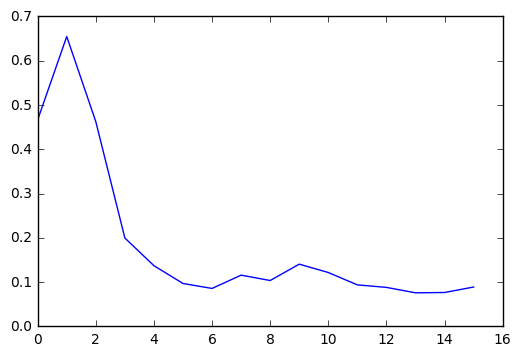

In [ ]:
# look at matches
import matplotlib.pyplot as plt

current_id = None
rows = []
for i, anid in enumerate(test_ids):
    if current_id and current_id != anid:
        print(current_id)
        plt.plot(np.array(model.predict(rows))[:, 0])
        plt.show()
        r = raw_input()
    rows.append(xtest[i])
    current_id = anid

In [ ]:
xtrain

In [ ]:
xtrain.shape

In [ ]:
ytrain.shape

In [ ]:
ytrain[0]

In [ ]:
matches[match_id]["features"]

In [ ]:
xtrain[15]

In [ ]:
ytrain[5]